<a href="https://colab.research.google.com/github/kaledai069/Crossword-Generator/blob/master/Backtracking_Feasible_%26_Infeasible_case_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Important Imports

In [36]:
import copy
import random
import heapq
import time
import pandas as pd
import requests
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from PIL import Image
from collections import deque, Counter
from queue import PriorityQueue
from pprint import pprint
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

### Crossword Variable & Back-tracking with Arc-Consistency

In [114]:
class Variable():

    ACROSS = "across"
    DOWN = "down"

    def __init__(self, i, j, direction, length):
        """Create a new variable with starting point, direction, and length."""
        self.i = i
        self.j = j
        self.direction = direction
        self.length = length
        self.cells = []
        for k in range(self.length):
            self.cells.append(
                (self.i + (k if self.direction == Variable.DOWN else 0),
                 self.j + (k if self.direction == Variable.ACROSS else 0))
            )

    def __hash__(self):
        return hash((self.i, self.j, self.direction, self.length))

    def __eq__(self, other):
        return (
            (self.i == other.i) and
            (self.j == other.j) and
            (self.direction == other.direction) and
            (self.length == other.length)
        )

    def __str__(self):
        return f"({self.i}, {self.j}) {self.direction} : {self.length}"

    def __repr__(self):
        direction = repr(self.direction)
        return f"Variable({self.i}, {self.j}, {direction}, {self.length})"

class Crossword():
    def __init__(self, grid, words_file, file_path = True):
        self.structure = []

        self.height = len(grid) # the number of rows in the grid
        self.width = len(grid[0]) # the number of columns in the grid
        for i in range(len(grid)):
            row = []
            for j in range(len(grid[0])):
                if grid[i][j] == '':
                  row.append(False)
                else:
                  row.append(True)
            self.structure.append(row)

        if not file_path:
            self.words = [word.upper() for word in words_file]

        else:
            # Save vocabulary list
            with open(words_file) as f:
                self.words = set(f.read().upper().splitlines()) # to remove all the duplicates
                self.words = list(self.words)
                for _ in range(5):
                    random.shuffle(self.words)
            self.words = set(self.words)

        # Determine variable set
        self.variables = set()

        for i in range(self.height):
            for j in range(self.width):

                # Vertical words
                starts_word = (
                    self.structure[i][j]
                    and (i == 0 or not self.structure[i - 1][j])
                )
                if starts_word:
                    length = 1
                    for k in range(i + 1, self.height):
                        if self.structure[k][j]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.DOWN,
                            length=length
                        ))

                # Horizontal words
                starts_word = (
                    self.structure[i][j]
                    and (j == 0 or not self.structure[i][j - 1])
                )
                if starts_word:
                    length = 1
                    for k in range(j + 1, self.width):
                        if self.structure[i][k]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.ACROSS,
                            length=length
                        ))

        # Compute overlaps for each word
        # For any pair of variables v1, v2, their overlap is either:
        #    None, if the two variables do not overlap; or
        #    (i, j), where v1's ith character overlaps v2's jth character
        self.overlaps = dict()
        self.overlaps_positions = dict()
        for v1 in self.variables:
            for v2 in self.variables:
                if v1 == v2:
                    continue
                cells1 = v1.cells
                cells2 = v2.cells
                intersection = set(cells1).intersection(cells2)
                if not intersection:
                    self.overlaps[v1, v2] = None
                else:
                    intersection = intersection.pop()
                    self.overlaps[v1, v2] = (
                        cells1.index(intersection),
                        cells2.index(intersection)
                    )
                    for cell in cells1:
                        for cell_ in cells2:
                            if cell == cell_:
                                self.overlaps_positions[v1, v2] = cell
                                break

    def neighbors(self, var):
        """Given a variable, return set of overlapping variables."""
        return set(
            v for v in self.variables
            if v != var and self.overlaps[v, var]
        )

class CrosswordCreator():

    def __init__(self, crossword, do_random = False):
        """
        Create new CSP crossword generate.
        """
        self.crossword = crossword
        self.ASSIGNMENT_COUNT = 0
        self.states = []
        self.do_random = do_random
        self.memoization_cache = dict()
        self.t_revise_time = 0
        self.t_revise_called = 0

        # setting up the domains for each of the variables
        self.domains = {
            var: [self.get_required_length_answers(var.length)]
            for var in self.crossword.variables
        }

    # enforcing the node consistency here
    def get_required_length_answers(self, ans_length):
        output = []
        for word in self.crossword.words:
            if len(word) == ans_length:
                output.append(word.upper())
        random.shuffle(output)
        output = output[:5000]
        return set(output)  # lets get the domain answers in list format

    def letter_grid(self, assignment):
        """
        Return 2D array representing a given assignment.
        """
        letters = [
            [None for _ in range(self.crossword.width)]
            for _ in range(self.crossword.height)
        ]
        for variable, word in assignment.items():
            direction = variable.direction
            for k in range(len(word)):
                i = variable.i + (k if direction == Variable.DOWN else 0)
                j = variable.j + (k if direction == Variable.ACROSS else 0)
                letters[i][j] = word[k]
        return letters

    def print(self, assignment):
        """
        Print crossword assignment to the terminal.
        """
        letters = self.letter_grid(assignment)
        for i in range(self.crossword.height):
            for j in range(self.crossword.width):
                if self.crossword.structure[i][j]:
                    print(letters[i][j] or " ", end="")
                else:
                    print("██", end="")
            print()

    def save(self, assignment, block_size = 25, f_size = 15, filename = None):
        """
        Save crossword assignment to an image file.
        """

        cell_size = block_size
        cell_border = 2
        interior_size = cell_size - 2 * cell_border
        letters = self.letter_grid(assignment)

        # Create a blank canvas
        img = Image.new(
            "RGBA",
            (self.crossword.width * cell_size,
             self.crossword.height * cell_size),
            "black"
        )
        font = ImageFont.truetype("/content/Roboto-Regular.ttf", f_size)
        draw = ImageDraw.Draw(img)

        for i in range(self.crossword.height):
            for j in range(self.crossword.width):

                rect = [
                    (j * cell_size + cell_border,
                     i * cell_size + cell_border),
                    ((j + 1) * cell_size - cell_border,
                     (i + 1) * cell_size - cell_border)
                ]
                if self.crossword.structure[i][j]:
                    draw.rectangle(rect, fill="white")
                    if letters[i][j]:
                        _, _, w, h = draw.textbbox((0, 0), letters[i][j], font=font)
                        draw.text(
                            (rect[0][0] + ((interior_size - w) / 2),
                             rect[0][1] + ((interior_size - h) / 2) - 5),
                            letters[i][j], fill="black", font=font
                        )
        if filename is not None:
            img.save(filename)
        return img

    ### here starts the main solving category
    def solve(self):
        """
        Enforce node and arc consistency, and then solve the CSP.
        """
        # self.enforce_node_consistency() # already being handled during initialization
        self.ac3()
        return self.backtrack(dict())

    def enforce_node_consistency(self):
        """
        Update `self.domains` such that each variable is node-consistent.
        (Remove any values that are inconsistent with a variable's unary
         constraints; in this case, the length of the word.)
        """
        for variable in self.crossword.variables:
            valid_words = set()
            for word in self.domains[variable][-1]:
                if len(word) == variable.length:
                    valid_words.add(word)
            self.domains[variable][-1] = valid_words

    def revise(self, x, y, forward_checking = False):
        """
            Make variable `x` arc consistent with variable `y`.
            To do so, remove values from `self.domains[x]` for which there is no
            possible corresponding value for `y` in `self.domains[y]`.

            Return True if a revision was made to the domain of `x`; return
            False if no revision was made.
        """

        start_t = time.time()
        revised = False
        overlap = self.crossword.overlaps[x, y]

        if overlap:
            y_chars = set(word[overlap[1]] for word in self.domains[y][-1])  # Use a set for faster membership tests
            x_domain = self.domains[x][-1]

            # Optimize: Use list comprehension for faster filtering
            x_domain = {word for word in x_domain if word[overlap[0]] in y_chars}

            if len(x_domain) < len(self.domains[x][-1]):
                revised = True
                if forward_checking:
                    self.domains[x].append(x_domain)
                else:
                    self.domains[x][-1] = x_domain

        end_t = time.time()
        self.t_revise_time += end_t - start_t
        self.t_revise_called += 1

        return revised

    def ac3(self, arcs=None, f_checking = False):
        if arcs is None:
            arcs = deque([(v1, v2) for v1 in self.crossword.variables for v2 in self.crossword.neighbors(v1)])
        else:
            arcs = deque(arcs)

        revised_arcs = set()

        while arcs:
            x, y = arcs.popleft()  # Efficient pop from the left

            # check if the arc has already been revised
            if (x, y) in revised_arcs:
                continue

            if self.revise(x, y, forward_checking = f_checking):
                if len(self.domains[x][-1]) == 0:
                    return False
                revised_arcs.add((x, y))
                for z in self.crossword.neighbors(x) - {y}:
                    arcs.append((z, x))
                    revised_arcs.add((z, x))
        return True

    def assignment_complete(self, assignment):
        self.ASSIGNMENT_COUNT += 1
        self.states.append(assignment)
        return len(assignment.keys()) == len(self.crossword.variables)

    # phind AI
    def consistent(self, assignment):
        """
            Return True if `assignment` is consistent (i.e., words fit in crossword
            puzzle without conflicting characters); return False otherwise.
        """
        values = set()
        for var, word in assignment.items():
            if word in values or len(word) != var.length:
                return False
            values.add(word)
            for neighbor in self.crossword.neighbors(var):
                overlap = self.crossword.overlaps[var, neighbor]
                if neighbor in assignment and assignment[var][overlap[0]] != assignment[neighbor][overlap[1]]:
                    return False
        return True


    # def order_domain_values(self, var, assignment, temp_var_domain):
    #     """
    #         Return a list of values in the domain of `var`, in order by
    #         the number of values they rule out for neighboring variables.
    #         The first value in the list should be the one that rules out
    #         the fewest values among the neighbors of `var`.
    #     """
    #     start_t = time.time()
    #     values_penalty = Counter()
    #     for neighbor in self.crossword.neighbors(var):
    #         if neighbor not in assignment:
    #             overlap = self.crossword.overlaps[var, neighbor]
    #             for value in temp_var_domain:
    #                 for value2 in self.domains[neighbor][-1]:
    #                     if value[overlap[0]] != value2[overlap[1]]:
    #                         values_penalty[value] += 1

    #     # Use a priority queue (heap) for efficient retrieval of the least constraining values
    #     priority_queue = [(-values_penalty[value], value) for value in temp_var_domain]
    #     heapq.heapify(priority_queue)
    #     end_t = time.time()
    #     print("Ordering the domain values: ", end_t - start_t)
    #     return [value for _, value in priority_queue]

    def order_domain_values(self, var, assignment, temp_var_domain):
        # start_t = time.time()
        values_penalty = Counter()
        for neighbor in self.crossword.neighbors(var):
            if neighbor not in assignment:
                overlap = self.crossword.overlaps[var, neighbor]
                neighbor_list = [value[overlap[1]] for value in list(self.domains[neighbor][-1])]

                for value in temp_var_domain:
                    letter_to_be_searched = neighbor_list.count(value[overlap[0]])
                    values_penalty[value] += len(neighbor_list) - letter_to_be_searched

        priority_queue = [(-values_penalty[value], value) for value in temp_var_domain]
        heapq.heapify(priority_queue)
        # end_t = time.time()
        # print("Ordering the domain values: ", end_t - start_t)
        return [value for _, value in priority_queue]


    def select_unassigned_variable(self, assignment):
        """
            Ordering:
              Return an unassigned variable not already part of `assignment`.
              Choose the variable with the minimum number of remaining values - MRV
              in its domain. If there is a tie, choose the variable with the highest
              degree. If there is a tie, any of the tied variables are acceptable
              return values.
        """
        var_penalty = {}
        for var in self.crossword.variables:
            if var not in assignment:
                var_penalty[var] = len(self.domains[var][-1])
                # var_penalty[var] = var.length
        vars = sorted(var_penalty, key= lambda v: var_penalty[v], reverse = True)

        # # if the two first variables have the same domain size
        # if len(vars) > 1 and var_penalty[vars[0]] == var_penalty[vars[1]]:
        #     # Check number of neighbors and return highest degree
        #     if len(self.crossword.neighbors(vars[0])) < len(self.crossword.neighbors(vars[1])):
        #         return vars[1]

        return vars[0]

    def backtrack(self, assignment):
        """
            Using Backtracking Search, take as input a partial assignment for the
            crossword and return a complete assignment if possible to do so.

            `assignment` is a mapping from variables (keys) to words (values).

            If no assignment is possible, return None.
        """
        if self.assignment_complete(assignment):
            return assignment  # base case

        # lets have some caching done here
        assignment_key = frozenset(assignment.items())
        if assignment_key in self.memoization_cache:
            self.ASSIGNMENT_COUNT += 1
            return self.memoization_cache[assignment_key]

        var = self.select_unassigned_variable(assignment)

        did_shorten_domain = False
        # print("Before: ", len(self.domains[var][-1]))

        temp_domain_var = self.domains[var][-1].copy()
        if len(assignment.keys()) > 0:
            for variable in self.crossword.variables:
                if var != variable and variable in assignment.keys():
                    overlap = self.crossword.overlaps[var, variable]
                    if overlap:
                        ref_cross_section_word = assignment[variable]
                        ref_intersection_letter = ref_cross_section_word[overlap[1]]

                        # Filter the words in the domain of var
                        did_shorten_domain = True
                        temp_domain_var = {word for word in temp_domain_var if word[overlap[0]] == ref_intersection_letter}

        if did_shorten_domain:
            self.domains[var].append(temp_domain_var)

        revised_neighbor_list = []
        # lets insert the ac3-arc consistency in the back-track recursive loop
        arc_list = deque([(neighbor, var) for neighbor in self.crossword.neighbors(var)])
        revised_arcs = set()

        while arc_list:
            x, y = arc_list.pop()

            if (x, y) in revised_arcs:
                continue

            if self.revise(x, y, forward_checking = True):
                revised_neighbor_list.append(x)

            for z in self.crossword.neighbors(x) - {y}:
                arc_list.append((z, x))
                revised_arcs.add((z, x))

        # print("After: ", len(self.domains[var][-1]))

        # lets introduce the randomness in iterating the values of the assigned variabel
        if self.do_random:
            shuffled_curr_domain = list(self.domains[var][-1].copy())
            random.shuffle(shuffled_curr_domain)

        domain_values = shuffled_curr_domain if self.do_random else list(self.domains[var][-1])

        for value in self.order_domain_values(var, assignment, domain_values):
            new_assignment = assignment.copy()
            new_assignment[var] = value
            if self.consistent(new_assignment):
                result = self.backtrack(new_assignment)

                if result is not None:
                    self.memoization_cache[assignment_key] = result
                    return result

        for n in revised_neighbor_list:
            self.domains[n].pop()

        if did_shorten_domain:
            self.domains[var].pop()

        self.memoization_cache[assignment_key] = None
        return None


import concurrent.futures

class CrosswordParallelSolver(CrosswordCreator):
    def __init__(self, crossword, do_random=False, num_threads = 6):
        super().__init__(crossword, do_random)
        self.num_threads = num_threads

    def parallel_backtrack(self, partial_assignment):
        if self.assignment_complete(partial_assignment):
            return partial_assignment

        var = self.select_unassigned_variable(partial_assignment)
        temp_domain_var = self.domains[var][-1].copy()

        # Forward checking
        for variable in self.crossword.variables:
            if var != variable and variable in partial_assignment:
                overlap = self.crossword.overlaps[var, variable]
                if overlap:
                    ref_cross_section_word = partial_assignment[variable]
                    ref_intersection_letter = ref_cross_section_word[overlap[1]]
                    temp_domain_var = {word for word in temp_domain_var if word[overlap[0]] == ref_intersection_letter}

        # if not temp_domain_var:
        #     return None  # Inconsistent assignment, backtrack

        futures = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            for value in temp_domain_var:
                new_assignment = partial_assignment.copy()
                new_assignment[var] = value
                futures.append(executor.submit(self.parallel_backtrack, new_assignment))

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                return result

        return None

    def solve_parallel(self):
        return self.parallel_backtrack(dict())


In [112]:
word_list_path = '/content/all_answers.txt'
word_list_path = "/content/new_answer_list.txt"

# 4x4 grid
# grid = [['', 'A', 'A', 'A'],
#         ['A', 'A', 'A', 'A'],
#         ['A', 'A', 'A', 'A'],
#         ['A', 'A', 'A', '']]

# # 5x5 grid
# grid = [['A', 'A', 'A', 'a', ''],
#         ['A', 'A', 'A', 'A', 'a'],
#         ['a', 'A', 'A', 'A', 'a'],
#         ['a', 'A', 'A', 'A', 'A'],
#         ['', 'a', 'A', 'A', 'A'],]

# 6x6 grid
grid = [['A', 'A', 'A', '', '', ''],
        ['A', 'A', 'A', 'A', 'A', ''],
        ['A', 'A', 'A', 'A', 'A', 'A'],
        ['A', 'A', 'A', 'A', 'A', 'A'],
        ['', 'A', 'A', 'A', 'A', 'A'],
        ['', '', '', 'A', 'A', 'A']]

start_t = time.time()
crossword = Crossword(grid, word_list_path)
creator = CrosswordCreator(crossword, do_random = True)
# creator = CrosswordParallelSolver(crossword, do_random = True)
assignment = creator.solve()
end_t = time.time()

print("Total time taken: ", end_t - start_t, 'seconds')
print("Total back-tracks: ", creator.ASSIGNMENT_COUNT)
print("Total time taken in revise function: ", creator.t_revise_time)
print("Total times revise function is called: ", creator.t_revise_called)
pprint(assignment)
creator.save(assignment, block_size = 50, f_size = 25)

KeyboardInterrupt: 

In [84]:
variable = list(creator.crossword.variables)[0]

start_t = time.time()
values_penalty = Counter()
for neighbor in creator.crossword.neighbors(variable):
    overlap = creator.crossword.overlaps[variable, neighbor]
    for value in tqdm(list(creator.domains[variable][0])[:5000], ncols = 120):
        for value_1 in list(creator.domains[neighbor][0])[:5000]:
            if value[overlap[0]] != value_1[overlap[1]]:
                values_penalty[value] += 1
end_t = time.time()
print("\nTotal time taken: ", end_t - start_t)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 351.04it/s]


Total time taken:  67.95315265655518


In [106]:
values_penalty = Counter()
no_samples = 10000
start_t = time.time()
for neighbor in creator.crossword.neighbors(variable):
    overlap = creator.crossword.overlaps[variable, neighbor]
    neighbor_list = [value[overlap[1]] for value in list(creator.domains[neighbor][0])[:no_samples]]

    for value in tqdm(list(creator.domains[variable][0])[:no_samples], ncols = 120):
        letter_to_be_searched = neighbor_list.count(value[overlap[0]])
        values_penalty[value] += len(neighbor_list) - letter_to_be_searched

priority_queue = [(-values_penalty[value], value) for value in list(creator.domains[variable][0])[:no_samples]]
heapq.heapify(priority_queue)

end_t = time.time()

print("\nTotal time taken: ", end_t - start_t)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4561.07it/s]


Total time taken:  11.032546520233154


#### Lets load the heavily loaded crosswords:

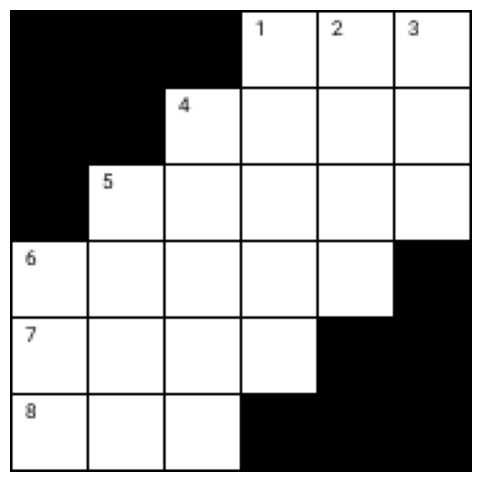

In [ ]:
from grid_generator_latest import generate_grid

json_data = generate_grid(grid_size = 6, b_factor = 3, display_grid = True)

rows = json_data['size']['rows']
cols = json_data['size']['cols']
grid = json_data['grid']
reshaped_grid = [grid[i:i + rows] for i in range(0, len(grid), rows)]

grid = []
for i in reshaped_grid:
    row = []
    for j in i:
        if j == '.':
            row.append('')
        else:
            row.append('A')
    grid.append(row)
# pprint(grid)

start_t = time.time()
crossword = Crossword(grid, word_list_path)
creator = CrosswordCreator(crossword, do_random = True)
# creator = CrosswordParallelSolver(crossword, do_random = True)
assignment = creator.solve()
end_t = time.time()
print("Total time taken: ", end_t - start_t, 'seconds')
print("Total back-tracks: ", creator.ASSIGNMENT_COUNT)
print("Total time taken in revise function: ", creator.t_revise_time)
print("Total times revise function is called: ", creator.t_revise_called)
pprint(assignment)
creator.save(assignment, block_size = 50, f_size = 25)

#### Basic analysis between variables and their intersection / overlaps.

In [ ]:
for var in crossword.variables:
    print("Variable", var)
    for neighbor in crossword.neighbors(var):
        print("Neighbor", neighbor)
        print("Overlap Position", crossword.overlaps[var, neighbor])
    print("-" * 50)

Variable (0, 0) down : 3
Neighbor (0, 0) across : 3
Overlap Position (0, 0)
Neighbor (2, 0) across : 4
Overlap Position (2, 0)
Neighbor (1, 0) across : 4
Overlap Position (1, 0)
--------------------------------------------------
Variable (3, 1) across : 3
Neighbor (1, 3) down : 3
Overlap Position (2, 2)
Neighbor (0, 1) down : 4
Overlap Position (0, 3)
Neighbor (0, 2) down : 4
Overlap Position (1, 3)
--------------------------------------------------
Variable (0, 1) down : 4
Neighbor (3, 1) across : 3
Overlap Position (3, 0)
Neighbor (2, 0) across : 4
Overlap Position (2, 1)
Neighbor (0, 0) across : 3
Overlap Position (0, 1)
Neighbor (1, 0) across : 4
Overlap Position (1, 1)
--------------------------------------------------
Variable (0, 2) down : 4
Neighbor (3, 1) across : 3
Overlap Position (3, 1)
Neighbor (2, 0) across : 4
Overlap Position (2, 2)
Neighbor (0, 0) across : 3
Overlap Position (0, 2)
Neighbor (1, 0) across : 4
Overlap Position (1, 2)
-------------------------------------

In [ ]:
creator.save(assignment, '/content/output_5x5_3.png')

In [ ]:
words = open("/content/all_answers.txt").read().splitlines()
for var, ans in assignment.items():
    if ans.lower() in words:
        print(ans)

BENITA
RUDNER
TIBIAL
OLDBAG
DEART
LOUIE
BOLED
EATRE
BLOB
BBRT
GATE
RLEE


Let me try something out here, so, if the answers are within the list of the words to be made the domain of the variables, the backtracking would easily find the answers.

<b> 1. Get clues and their gold answers from NYT or somewhere <br>
<b> 2. Form a words dictionary of about 5000 words which would include those answers <br>
<b> 3. Test if the back-tracking would find the answers

In [ ]:
def get_grid_answers(dateStr):

    headers = {
        'Referer': 'https://www.xwordinfo.com/JSON/'
    }
    # mm/dd/yyyy
    url = 'https://www.xwordinfo.com/JSON/Data.ashx?date=' + dateStr

    response = requests.get(url, headers=headers)

    answer_list = []
    two_d_grid = []
    grid_structure = []

    grid_data = {}
    if response.status_code == 200:
        bytevalue = response.content
        jsonText = bytevalue.decode('utf-8').replace("'", '"')
        grid_data = json.loads(jsonText)
        answer_list.extend(grid_data['answers']['across'])
        answer_list.extend(grid_data['answers']['down'])

        rows = cols = grid_data['size']['rows']
        initial_grid = grid_data['grid']

        for i in range(0, len(initial_grid), cols):
            two_d_grid.append(initial_grid[i:i+cols])

        for grid_row in two_d_grid:
            row = []
            for element in grid_row:
                if element == '.':
                    row.append('')
                else:
                    row.append('#')
            grid_structure.append(row)
        return answer_list, grid_structure
    else:
        print(f"Request failed with status code {response.status_code}.")
        return None

<b> Let's prepare a custom answer list

In [ ]:
words = open("/content/all_answers.txt").read().splitlines()
words_df = pd.DataFrame(words, columns = ['answer'])
words_df['answer_len'] = words_df['answer'].apply(len)
words_df.head(5)

,answer,answer_len
0,taxpro,6
1,warm,4
2,decaf,5
3,mussel,6
4,aaamap,6


In [ ]:
def get_answers_by_len(answers_df, answer_len, no_samples = 100):
    grouped_by_len = answers_df.groupby('answer_len')
    out_answers_list = grouped_by_len.get_group(answer_len)['answer'].tolist()
    random.shuffle(out_answers_list)
    return out_answers_list[:no_samples]

In [ ]:
date_str = "1/20/2023"
answer_list, grid = get_grid_answers(date_str)

if answer_list is not None:
    answer_len_ = set()
    for answer in answer_list:
        answer_len_.add(len(answer))

    custom_answer_list = []
    for ans_len in answer_len_:
        custom_answer_list.extend(get_answers_by_len(words_df, ans_len, 110))

    print('Length of Custom Answer List before addition: ', len(custom_answer_list))

    custom_answer_list.extend(answer_list)
    print("Length of Custom Answer List after addition: ", len(custom_answer_list))

Length of Custom Answer List before addition:  880
Length of Custom Answer List after addition:  948


Let's now test the hypothesis

In [ ]:
start_t = time.time()
crossword = Crossword(grid, custom_answer_list, False)
# creator = CrosswordCreator(crossword)
creator = CrosswordParallelSolver(crossword, do_random = True)
assignment = creator.solve()
end_t = time.time()

print("Total time taken: ", end_t - start_t)
assignment

KeyboardInterrupt: 

In [ ]:
words = open("/content/all_answers.txt").read().splitlines()
print(len(answer_list))

counter = 0
for ans in answer_list:
    if ans.lower() in words:
        counter += 1
counter

66


66

In [ ]:
for i, state in tqdm(enumerate(creator.states), ncols = 70):
    creator.save(state, f"/content/Images 4x4/output_4x4_{i}.png")

1777it [01:37, 18.21it/s]


In [ ]:
creator.save(assignment, '/content/output_21x21_1.png')

<b> Lets make a gif out of this

In [ ]:
def sort_by_last_digit(filename):
    last_digit = int(filename.split('_')[-1].split('.')[0])
    return last_digit

def create_gif(images_folder, output_gif_path):
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))])
    image_files = sorted(image_files, key = sort_by_last_digit)

    images = []
    for image_file in tqdm(image_files, ncols = 50):
        image_path = os.path.join(images_folder, image_file)
        img = Image.open(image_path)
        images.append(img)

    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration = 40, loop = 0)

images_folder = "/content/Images 4x4"
output_gif_path = "/content/output 4x4_1.gif"

create_gif(images_folder, output_gif_path)

100%|██████| 1777/1777 [00:00<00:00, 10534.18it/s]


In [ ]:
vocabulary = open("/content/all_answers.txt").read().splitlines()

vocabulary = [word for word in vocabulary if len(word) == 5]

t_time = 0
for _ in range(10):
    start_t = time.time()
    filtered_words = [word for word in vocabulary if word[0] == 'h' and word[1] == 'a' and word[3] == 'b']
    end_t = time.time()
    t_time += end_t - start_t
print("Total time taken by list comprehension: ", t_time / 10 * 1000, "ms")
filtered_words

Total time taken by list comprehension:  5.096344947814941 ms


['haabs', 'hambo', 'halbe']

In [ ]:
t_time = 0

for _ in range(10):
    start_t = time.time()
    pattern = re.compile(r'h.{1}a.{1}b')
    filtered_words = [word for word in vocabulary if pattern.match(word)]
    end_t = time.time()
    t_time += end_t - start_t
print("Total time taken by regex: ", t_time / 10 * 1000, 'ms')

Total time taken by regex:  18.933749198913574 ms


In [ ]:
words = open("/content/all_answers.txt").read().splitlines()

t_time = 0
words = [word for word in words if len(word) == 5]

char_array = np.array([list(word) for word in words])
print(char_array.shape)

for _ in range(10):
    start_t = time.time()
    vocabulary = np.array(words)
    condition = (char_array[:, 0] == 'h') & (char_array[:, 1] == 'a') & (char_array[:, 3] == 'b')
    filtered_words = vocabulary[condition].tolist()
    end_t = time.time()
    t_time += end_t - start_t

print("Total time taken by numpy: ", t_time / 10 * 1000, 'ms')
print(type(filtered_words))

(30213, 5)
Total time taken by numpy:  13.385152816772461 ms
<class 'list'>


So, among various retrieval method for given pattern, i find that if the char_array is previously-given then numpy method is the fastest and efficeint

In [ ]:
class Variable():

    ACROSS = "across"
    DOWN = "down"

    def __init__(self, i, j, direction, length):
        """Create a new variable with starting point, direction, and length."""
        self.i = i
        self.j = j
        self.direction = direction
        self.length = length
        self.cells = []
        for k in range(self.length):
            self.cells.append(
                (self.i + (k if self.direction == Variable.DOWN else 0),
                 self.j + (k if self.direction == Variable.ACROSS else 0))
            )

    def __hash__(self):
        return hash((self.i, self.j, self.direction, self.length))

    def __eq__(self, other):
        return (
            (self.i == other.i) and
            (self.j == other.j) and
            (self.direction == other.direction) and
            (self.length == other.length)
        )

    def __str__(self):
        return f"({self.i}, {self.j}) {self.direction} : {self.length}"

    def __repr__(self):
        direction = repr(self.direction)
        return f"Variable({self.i}, {self.j}, {direction}, {self.length})"

class Crossword():
    def __init__(self, grid, words_file, file_path = True):
        self.structure = []

        self.height = len(grid) # the number of rows in the grid
        self.width = len(grid[0]) # the number of columns in the grid
        for i in range(len(grid)):
            row = []
            for j in range(len(grid[0])):
                if grid[i][j] == '':
                  row.append(False)
                else:
                  row.append(True)
            self.structure.append(row)

        if not file_path:
            self.words = [word.upper() for word in words_file]

        else:
            # Save vocabulary list
            with open(words_file) as f:
                self.words = set(f.read().upper().splitlines()) # to remove all the duplicates
                self.words = list(self.words)
                for _ in range(5):
                    random.shuffle(self.words)
            self.words = set(self.words)

        # Determine variable set
        self.variables = set()

        for i in range(self.height):
            for j in range(self.width):

                # Vertical words
                starts_word = (
                    self.structure[i][j]
                    and (i == 0 or not self.structure[i - 1][j])
                )
                if starts_word:
                    length = 1
                    for k in range(i + 1, self.height):
                        if self.structure[k][j]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.DOWN,
                            length=length
                        ))

                # Horizontal words
                starts_word = (
                    self.structure[i][j]
                    and (j == 0 or not self.structure[i][j - 1])
                )
                if starts_word:
                    length = 1
                    for k in range(j + 1, self.width):
                        if self.structure[i][k]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.ACROSS,
                            length=length
                        ))

        # Compute overlaps for each word
        # For any pair of variables v1, v2, their overlap is either:
        #    None, if the two variables do not overlap; or
        #    (i, j), where v1's ith character overlaps v2's jth character
        self.overlaps = dict()
        self.overlaps_positions = dict()
        for v1 in self.variables:
            for v2 in self.variables:
                if v1 == v2:
                    continue
                cells1 = v1.cells
                cells2 = v2.cells
                intersection = set(cells1).intersection(cells2)
                if not intersection:
                    self.overlaps[v1, v2] = None
                else:
                    intersection = intersection.pop()
                    self.overlaps[v1, v2] = (
                        cells1.index(intersection),
                        cells2.index(intersection)
                    )
                    for cell in cells1:
                        for cell_ in cells2:
                            if cell == cell_:
                                self.overlaps_positions[v1, v2] = cell
                                break

    def neighbors(self, var):
        """Given a variable, return set of overlapping variables."""
        return set(
            v for v in self.variables
            if v != var and self.overlaps[v, var]
        )

class CrosswordCreator():

    def __init__(self, crossword, n = None):
        """
        Create new CSP crossword generate.
        """
        self.crossword = crossword
        self.ASSIGNMENT_COUNT = 0
        self.states = []
        self.no_values = n
        # setting up the domains for each of the variables
        self.domains = {
            var: self.get_required_length_answers(var.length)
            for var in self.crossword.variables
        }

    # enforcing the node consistency here
    def get_required_length_answers(self, ans_length):
        output = []
        for word in self.crossword.words:
            if len(word) == ans_length:
                output.append(word)
        random.shuffle(output)
        # output = output[:self.no_values]
        return output

    def letter_grid(self, assignment):
        """
        Return 2D array representing a given assignment.
        """
        letters = [
            [None for _ in range(self.crossword.width)]
            for _ in range(self.crossword.height)
        ]
        for variable, word in assignment.items():
            direction = variable.direction
            for k in range(len(word)):
                i = variable.i + (k if direction == Variable.DOWN else 0)
                j = variable.j + (k if direction == Variable.ACROSS else 0)
                letters[i][j] = word[k]
        return letters

    def print(self, assignment):
        """
        Print crossword assignment to the terminal.
        """
        letters = self.letter_grid(assignment)
        for i in range(self.crossword.height):
            for j in range(self.crossword.width):
                if self.crossword.structure[i][j]:
                    print(letters[i][j] or " ", end="")
                else:
                    print("██", end="")
            print()

    def save(self, assignment, filename):
        """
        Save crossword assignment to an image file.
        """
        from PIL import Image, ImageDraw, ImageFont
        cell_size = 100
        cell_border = 2
        interior_size = cell_size - 2 * cell_border
        letters = self.letter_grid(assignment)

        # Create a blank canvas
        img = Image.new(
            "RGBA",
            (self.crossword.width * cell_size,
             self.crossword.height * cell_size),
            "black"
        )
        font = ImageFont.truetype("/content/Roboto-Regular.ttf", 80)
        draw = ImageDraw.Draw(img)

        for i in range(self.crossword.height):
            for j in range(self.crossword.width):

                rect = [
                    (j * cell_size + cell_border,
                     i * cell_size + cell_border),
                    ((j + 1) * cell_size - cell_border,
                     (i + 1) * cell_size - cell_border)
                ]
                if self.crossword.structure[i][j]:
                    draw.rectangle(rect, fill="white")
                    if letters[i][j]:
                        _, _, w, h = draw.textbbox((0, 0), letters[i][j], font=font)
                        draw.text(
                            (rect[0][0] + ((interior_size - w) / 2),
                             rect[0][1] + ((interior_size - h) / 2) - 10),
                            letters[i][j], fill="black", font=font
                        )
        img.save(filename)

    ### here starts the main solving category
    def solve(self):
        """
        Enforce node and arc consistency, and then solve the CSP.
        """
        # self.enforce_node_consistency() # already being handled during initialization
        self.ac3()
        return self.backtrack(dict())

    def enforce_node_consistency(self):
        """
        Update `self.domains` such that each variable is node-consistent.
        (Remove any values that are inconsistent with a variable's unary
         constraints; in this case, the length of the word.)
        """
        for variable in self.crossword.variables:
            valid_words = set()
            for word in self.domains[variable]:
                if len(word) == variable.length:
                    valid_words.add(word)
            self.domains[variable] = valid_words

    def revise(self, x, y):
        """
            Make variable `x` arc consistent with variable `y`.
            To do so, remove values from `self.domains[x]` for which there is no
            possible corresponding value for `y` in `self.domains[y]`.

            Return True if a revision was made to the domain of `x`; return
            False if no revision was made.
        """
        revised = False
        overlap = self.crossword.overlaps[x, y]
        y_chars = {word[overlap[1]] for word in self.domains[y]}  # Precompute the y's second character set
        self.domains[x] = {word for word in self.domains[x] if word[overlap[0]] in y_chars}
        if len(self.domains[x]) < len(self.domains[y]):
            revised = True
        return revised

    def ac3(self, arcs=None):
        if arcs is None:
            arcs = deque([(v1, v2) for v1 in self.crossword.variables for v2 in self.crossword.neighbors(v1)])
        else:
            arcs = deque(arcs)

        while arcs:
            x, y = arcs.popleft()  # Efficient pop from the left
            if self.revise(x, y):
                if not self.domains[x][-1]:
                    return False
                for z in self.crossword.neighbors(x) - {y}:
                    arcs.append((z, x))
        return True

    def assignment_complete(self, assignment):
        """
        Return True if `assignment` is complete (i.e., assigns a value to each
        crossword variable); return False otherwise.
        """
        self.ASSIGNMENT_COUNT += 1
        # if len(assignment.keys()) / len(self.crossword.variables) >= 0.85:
        #     return True
        self.states.append(assignment)
        complete = True
        vars_in_assignment = set(var for var in assignment)
        # Checking if all vars in the crossword has been assigned
        if vars_in_assignment != self.crossword.variables:
            complete = False
        for var in assignment:
            # making sure no var is empty
            assert isinstance(assignment[var], str)
            if not assignment[var]:
                complete = False
        return complete

    # phind AI
    def consistent(self, assignment):
        """
          Return True if `assignment` is consistent (i.e., words fit in crossword
          puzzle without conflicting characters); return False otherwise.
        """
        values = set()
        for var, word in assignment.items():
            if word in values or len(word) != var.length:
                return False
            values.add(word)
            for neighbor in self.crossword.neighbors(var):
                overlap = self.crossword.overlaps[var, neighbor]
                if neighbor in assignment and assignment[var][overlap[0]] != assignment[neighbor][overlap[1]]:
                    return False
        return True

    def order_domain_values(self, var, assignment, temp_var_domain):
        """
        Return a list of values in the domain of `var`, in order by
        the number of values they rule out for neighboring variables.
        The first value in the list should be the one that rules out
        the fewest values among the neighbors of `var`.
        """
        values_penalty = {value: 0 for value in self.domains[var]}
        for neighbor in self.crossword.neighbors(var):
            if neighbor not in assignment:
                overlap = self.crossword.overlaps[var, neighbor]
                for value in temp_var_domain:
                    for value2 in self.domains[neighbor]:
                        if value[overlap[0]] != value2[overlap[1]]:
                            values_penalty[value] += 1

        # Use a priority queue (heap) for efficient retrieval of the least constraining values
        priority_queue = [(-values_penalty[value], value) for value in temp_var_domain]
        heapq.heapify(priority_queue)

        return [value for _, value in priority_queue]

    def select_unassigned_variable(self, assignment):
        """
        Ordering:
          Return an unassigned variable not already part of `assignment`.
          Choose the variable with the minimum number of remaining values - MRV
          in its domain. If there is a tie, choose the variable with the highest
          degree. If there is a tie, any of the tied variables are acceptable
          return values.
        """

        var_penalty = {}
        for var in self.crossword.variables:
            if var not in assignment:
                # var_penalty[var] = len(self.domains[var][-1])
                var_penalty[var] = var.length
        vars = sorted(var_penalty, key= lambda v: var_penalty[v], reverse = True)
        # return vars[0]
        # if the two first variables have the same domain size
        if len(vars) > 1 and var_penalty[vars[0]] == var_penalty[vars[1]]:
            # Check number of neighbors and return highest degree
            if len(self.crossword.neighbors(vars[0])) < len(self.crossword.neighbors(vars[1])):
                return vars[1]
        return vars[0]

    # # Modify the backtrack method
    # def backtrack(self, assignment):
    #     """
    #     Using Backtracking Search, take as input a partial assignment for the
    #     crossword and return a complete assignment if possible to do so.

    #     `assignment` is a mapping from variables (keys) to words (values).

    #     If no assignment is possible, return None.
    #     """
    #     if self.assignment_complete(assignment):
    #         return assignment  # base case
    #     var = self.select_unassigned_variable(assignment)
    #     print("Before: ", len(self.domains[var]))
    #     if len(assignment.keys()) > 0:
    #         for variable in self.crossword.variables:
    #             if var == variable:
    #                 continue
    #             if variable in assignment.keys():
    #                 overlap = self.crossword.overlaps[var, variable]
    #                 # overlap[1] -> index of the overlapping letter in the y i.e. Variable
    #                 # overlap[0] -> index of the overlapping letter in the x i.e. var
    #                 if overlap:
    #                     ref_cross_section_word = assignment[variable]
    #                     ref_intersection_letter = ref_cross_section_word[overlap[1]]
    #                     # i.e. in the var domain there should be letter 'ref_intersection_letter' in the overlap[0] position
    #                     self.domains[var] = [word for word in self.domains[var] if word[overlap[0]] == ref_intersection_letter]

    #     # for value in self.order_domain_values(var, assignment):
    #     print("After: ", len(self.domains[var]))
    #     new_assignment = assignment.copy()
    #     for value in self.domains[var]:
    #          # or dict(assignment)
    #         new_assignment[var] = value
    #         if self.consistent(new_assignment):
    #             result = self.backtrack(new_assignment)
    #             if result is not None:
    #                 return result
    #     return None

    def backtrack(self, assignment):
        """
        Using Backtracking Search, take as input a partial assignment for the
        crossword and return a complete assignment if possible to do so.

        `assignment` is a mapping from variables (keys) to words (values).

        If no assignment is possible, return None.
        """
        if self.assignment_complete(assignment):
            return assignment  # base case

        var = self.select_unassigned_variable(assignment)

        # print("Before: ", len(self.domains[var]))

        # Create a copy of self.domains for this branch
        original_domains = {var: set(words) for var, words in self.domains.items()}


        # original_domain = set(self.domains[var][-1])

        did_shorten_domain = False

        if len(assignment.keys()) > 0:
            for variable in self.crossword.variables:
                if var == variable:
                    continue

                if variable in assignment.keys():
                    overlap = self.crossword.overlaps[var, variable]
                    if overlap:
                        ref_cross_section_word = assignment[variable]
                        ref_intersection_letter = ref_cross_section_word[overlap[1]]
                        # Filter the words in the domain of var

                        self.domains[var] = {word for word in self.domains[var] if word[overlap[0]] == ref_intersection_letter}
                        did_shorten_domain = True

                        # self.domains[var].append({word for word in self.domains[var][-1] if word[overlap[0]] == ref_intersection_letter})

        # print("After: ", len(self.domains[var]))

        new_assignment = assignment.copy()
        for value in self.domains[var]:
            # Use the original_domains during recursive calls
            self.domains = original_domains.copy()
            new_assignment[var] = value
            if self.consistent(new_assignment):
                # self.domains[var].append(original_domain.copy())
                result = self.backtrack(new_assignment)

                if result is not None:
                    return result

        # if did_shorten_domain:
        #     self.domains[var].pop()
        return None
